In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
import scipy.stats as stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
c = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
c.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Задание 1.**  
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

Нарисуем гистограммы значений LIMIT_BAL для двух групп - вернувших и не вернувших кредит.

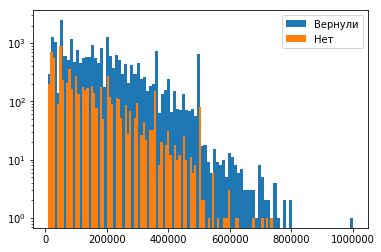

In [4]:
c0 = c[c.default==0].LIMIT_BAL.values
c1 = c[c.default==1].LIMIT_BAL.values

bins = 100
log = True

pylab.hist(c0, log=log, label='Вернули', bins=bins)
pylab.hist(c1, log=log, label='Нет', bins=bins)
pylab.legend()

Будем решать задачу с помощью бутстрепа.

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
np.random.seed(0)

c0_median_scores = list(map(np.median, get_bootstrap_samples(c0, 1000)))
c1_median_scores = list(map(np.median, get_bootstrap_samples(c1, 1000)))

print("95% confidence interval for c0 median credit limit:",  stat_intervals(c0_median_scores, 0.05))
print("95% confidence interval for c1 median credit limit:",  stat_intervals(c1_median_scores, 0.05))

95% confidence interval for c0 median credit limit: [150000. 150000.]
95% confidence interval for c1 median credit limit: [80000. 90000.]


Видим, что медианы не совпадают. Люди, не возвращающие кредит, запрашивают меньшую сумму.

**Проверка равенства распределений**

Проверяем гипотезу о равенстве распределений:  
$H_0\colon F_{с_0}(x) = F_{с_1}(x)$ - распределения выборок равны

$H_1\colon F_{с_0}(x) = F_{с_1}(x + \Delta), \Delta\neq 0$ - распределения отличаются на некоторую величину сдвига

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [9]:
def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [10]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [11]:
def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [12]:
print('p-value: %f' % permutation_test(c0, c1, max_permutations=1000))

p-value: 0.001000


Гипотеза $H_0$ уверенно отвергается (pvalue очень мало). Значит, распределения не совпадают.  
Результат является практически значимым, поскольку разница между медианами существенно большая.

**Задание 2.**  
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

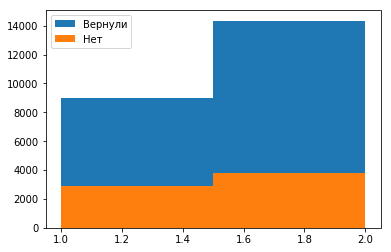

In [13]:
s0 = c[c.default==0].SEX.values
s1 = c[c.default==1].SEX.values

bins = 2
log = False

pylab.hist(s0, log=log, label='Вернули', bins=bins)
pylab.hist(s1, log=log, label='Нет', bins=bins)
pylab.legend()

Из гистограммы не очевидно, что есть какая-нибудь разница в гендерном составе по группам: и там, и там женщин примерно в 1.5 раза больше, чем мужчин.
Под гендерным составом выборки будем понимать пропорцию m/f, где m - количество мужчин, f - количество женщин.
Сначала проверим доверительные интервалы на основе нормального распределения.  
Гипотезы:  
$𝐻_0$: гендерный состав одинаков  
$𝐻_1$: гендерный состав отличается

In [14]:
confint_0 = proportion_confint(np.where(s0 == 1)[0].shape[0], s0.shape[0])
confint_1 = proportion_confint(np.where(s1 == 1)[0].shape[0], s1.shape[0])

print('Confident interval for "men/women proportion for "default = 0": [%.4f, %.4f]' % confint_0)
print('Confident interval for "men/women proportion for "default = 1": [%.4f, %.4f]' % confint_1)

Confident interval for "men/women proportion for "default = 0": [0.3796, 0.3921]
Confident interval for "men/women proportion for "default = 1": [0.4210, 0.4449]


Доверительные интервалы не пересекаются, следовательно гендерный состав различается.  

Применим теперь Z-критерий для доли для двух независимых выборок.  
Гипотезы:  
$𝐻_0$: гендерный состав одинаков  
$𝐻_1$: гендерный состав отличается

In [15]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [16]:
def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [17]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(s0 - 2), np.abs(s1 - 2))))

p-value: 0.000000000004473


Гипотеза $𝐻_0$  уверенно отвергается (pvalue очень мало). Значит, равенства нет.

**Задание 3.**  
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборот, не отдаст долг ?

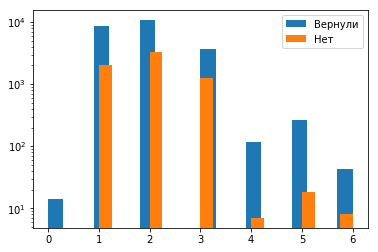

In [18]:
e0 = c[c.default==0].EDUCATION.values
e1 = c[c.default==1].EDUCATION.values

bins = 20
log = True

pylab.hist(e0, log=log, label='Вернули', bins=bins)
pylab.hist(e1, log=log, label='Нет', bins=bins)
pylab.legend()

Из графиков можно сделать следующие выводы: 1) доктора наук всегда возвращают кредиты; 2) люди со средним и высшим образованием показывают примерно одинаковое распределение по части возврата/невозврата кредитов; 3) люди с начальным и прочим образованием более склонны возвращать кредиты, нежели люди с более высоким образованием (кроме докторов).

In [19]:
e_dict = {0 : 'доктор', 1 : 'магистр', 2 : 'бакалавр', 3 : 'выпускник школы',
          4 : 'начальное образование', 5 : 'прочее', 6 : 'нет данных'}
e, i0, i1 = [], [], []
for i in range(7):
    i0.append(sum([1 for j in e0 if j==i], dtype='int'))
    i1.append(sum([1 for j in e1 if j==i], dtype='int'))
    e.append(round(i0[i]/(i0[i] + i1[i]), 2))

ec = pd.DataFrame([e, [x+y for x,y in zip(i0, i1)], i0, i1]).T
ec.columns = ['% возвращающих долг', 'ожидался возврат долга', 'вернувших', 'не вернувших']
ec.rename(index=e_dict)

,% возвращающих долг,ожидался возврат долга,вернувших,не вернувших
доктор,1.00,14.0,14.0,0.0
магистр,0.81,10585.0,8549.0,2036.0
бакалавр,0.76,14030.0,10700.0,3330.0
выпускник школы,0.75,4917.0,3680.0,1237.0
начальное образование,0.94,123.0,116.0,7.0
прочее,0.94,280.0,262.0,18.0
нет данных,0.84,51.0,43.0,8.0


Чтобы привести данные в таблице к одному масштабу, можно прологарифмировать значения.

In [20]:
ec = pd.DataFrame([e, np.log([x+y for x,y in zip(i0, i1)]).round(2), np.log(i0).round(2), np.log(i1).round(2)]).T
ec.columns = ['% возвращающих долг', 'ожидался возврат долга', 'вернувших', 'не вернувших']
ec.rename(index=e_dict)

c:\users\vetix\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


,% возвращающих долг,ожидался возврат долга,вернувших,не вернувших
доктор,1.00,2.64,2.64,-inf
магистр,0.81,9.27,9.05,7.62
бакалавр,0.76,9.55,9.28,8.11
выпускник школы,0.75,8.50,8.21,7.12
начальное образование,0.94,4.81,4.75,1.95
прочее,0.94,5.63,5.57,2.89
нет данных,0.84,3.93,3.76,2.08


Итак, степень доктора является наилучшим индикатором того, что человек отдаст долг, а человек со средним образованием, но без высшего - наоборот, не отдаст.

Проведем проверку гипотезы о том, что образование не влияет на то, вернет ли человек долг. Фактически, это означает, что распределение клиентов по уровню образования - равномерное.
Итак, проведем проверку на соответствие данного распределения равномерному, с помощью критерия согласия Пирсона хи-квадрат.  
Гипотезы:  
$H_0$: рассматриваемая величина имеет равномерное распределение  
$H_1$: не имеет

In [21]:
stats.chisquare(i0)  # Распределение по образованию среди людей, возвращающих кредиты

Power_divergenceResult(statistic=36917.35687382297, pvalue=0.0)

In [22]:
stats.chisquare(i1)  # Распределение по образованию среди людей, не возвращающих кредиты

Power_divergenceResult(statistic=11048.390295358648, pvalue=0.0)

In [23]:
stats.chisquare(i0+i1)  # Распределение по образованию среди всех людей, берущих кредиты

Power_divergenceResult(statistic=71717.81573333332, pvalue=0.0)

Видим, что гипотеза о равномерности, т.е. независимости возврата кредитов от образования, уверенно отвергается по всем группам.

**Задание 4.**  
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

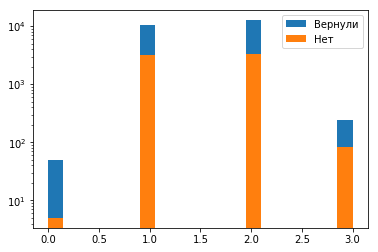

In [24]:
m0 = c[c.default==0].MARRIAGE.values
m1 = c[c.default==1].MARRIAGE.values

bins = 20
log = True

pylab.hist(m0, log=log, label='Вернули', bins=bins)
pylab.hist(m1, log=log, label='Нет', bins=bins)
pylab.legend()

Исследуем возможную связь семейного статуса с индикатором дефолта имеется. Проверим ее по критериям Пирсона и Спирмена:

In [27]:
stats.pearsonr(c.MARRIAGE, c.default)

(-0.02433921568340417, 2.4853638863386893e-05)

In [28]:
stats.spearmanr(c.MARRIAGE, c.default)

SpearmanrResult(correlation=-0.026489789964479267, pvalue=4.45843573619923e-06)

По обоим критериям корреляция получается близкой к нулю, т.е. связи нет.

**Задание 5.**  
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   
a)  о равенстве медианных значений возрастов людей   
b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  
Значимы ли полученные результаты с практической точки зрения ?

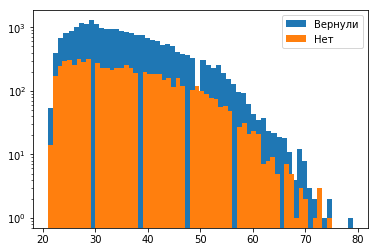

In [29]:
a0 = c[c.default==0].AGE.values
a1 = c[c.default==1].AGE.values

bins = 60
log = True

pylab.hist(a0, log=log, label='Вернули', bins=bins)
pylab.hist(a1, log=log, label='Нет', bins=bins)
pylab.legend()

Судя по картинке, распределения по вернувшим/не вернувшим похожи.  
Задачу сравнения медианных значений будем решать опять с помощью бутстрепа.

In [30]:
np.random.seed(0)

a0_median_scores = list(map(np.median, get_bootstrap_samples(a0, 1000)))
a1_median_scores = list(map(np.median, get_bootstrap_samples(a1, 1000)))

print("95% confidence interval for a0 median credit limit:",  stat_intervals(a0_median_scores, 0.05))
print("95% confidence interval for a1 median credit limit:",  stat_intervals(a1_median_scores, 0.05))

95% confidence interval for a0 median credit limit: [34. 34.]
95% confidence interval for a1 median credit limit: [34. 35.]


Итак, интервальные оценки для медианы пересекаются.  
Построим интервальную оценку для разности медиан.

In [31]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(a0_median_scores, a1_median_scores)))

In [32]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% confidence interval for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% confidence interval for the difference between medians: [0.000000, 1.000000]


Доверительный интервал содержит ноль, значит, значения медиан не различаются.

Проверим теперь гипотезу о равенстве распределений для независимых выборок:  
$H_0\colon F_{с_0}(x) = F_{с_1}(x)$ - распределения выборок равны

$H_1\colon F_{с_0}(x) = F_{с_1}(x + \Delta), \Delta\neq 0$ - распределения отличаются на некоторую величину сдвига

In [33]:
print('p-value: %f' % permutation_test(a0, a1, max_permutations=1000))

p-value: 0.014000


p-value мало (<0.05), значит, нулевая гипотеза отвергается на уровне 0.05.